In [1]:
!pip install poetry
!pip install ray
!pip install tensorboardX

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = 'drive/My Drive/DL project'
import sys
sys.path.append(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New section

In [3]:
modelName = 'Ren_LSTM'
import datetime
import getpass
import json
import os
import pathlib
from shutil import copyfile

import torch
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from config_Ren_LSTM import code_path, data_path, figure_path, model_path
from src.data import DataframeDataLoader
from src.evaluation_Ren_LSTM import evaluateModel
from src.load_data import dataLoader
from src.models.Ren_LSTM import DilatedNet
from src.parameter_sets.par import *
from src.tools_Ren_LSTM import train_cgm


from optimizeHypers_Ren_LSTM import searchBestHypers, test_rmse
from pathlib import Path

In [4]:
# %load_ext autoreload
# %autoreload 2

# Paths to data, code, figures, etc. should be set in config.py.
# Initialize the config.py file by copying from config.template.py.
# ---------------------------------------------------------------------
# DEFINE MODEL, PARAMETERS AND DATA
# - Change <par> to the name of file containing your parameters
# - Change <hediaNet> to the name of file containing your model architecture and DilatedNet to the name
#   of your model. Also change in train_cgm and optmizeHypers.py
# ---------------------------------------------------------------------


# Tensorboard log setup
# Create a directory for the model if it doesn't already exist
current_time = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
user = getpass.getuser()
model_id = f'id_{current_time}_{user}'
model_path_id = model_path / model_id
model_path_id.mkdir(exist_ok=True, parents=True)
#pathlib.Path(model_path_id).mkdir(parents=True, exist_ok=True)
model_figure_path = figure_path / model_id
model_figure_path.mkdir(exist_ok=True, parents=True)
#pathlib.Path(model_figure_path).mkdir(parents=True, exist_ok=True)





In [5]:

# ---------------------------------------------------------------------
# DEFINE DATA
# ---------------------------------------------------------------------
# Define data object
data_pars = {}
data_pars['path'] = data_path
data_pars['train_data'] = train_data
data_pars['test_data'] = test_data
data_pars['validation_data'] = val_data

data_pars['start_date_train'] = start_date_train
data_pars['start_date_test'] = start_date_test
data_pars['start_date_validation'] = start_date_val

data_pars['end_date_train'] = end_date_train
data_pars['end_date_test'] = end_date_test
data_pars['end_date_validation'] = end_date_val


data_obj = dataLoader(data_pars, features, n_steps_past=16,
                      n_steps_future=6,
                      allowed_gap=10,
                      scaler=StandardScaler())


Optimize hyperparameters

In [6]:
import os
os.chdir('/content/drive/My Drive/DL project/')

In [7]:
#searchBestHypers(num_samples=50, max_num_epochs=30, n_epochs_stop=10, grace_period=5, gpus_per_trial=1, data_obj=data_obj)

2021-01-03 16:32:10,244	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8265
2021-01-03 16:32:14,221	WARNING experiment.py:285 -- No name detected on trainable. Using DEFAULT.
2021-01-03 16:32:14,224	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 1.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 1/2 CPUs, 0/1 GPUs, 0.0/7.23 GiB heap, 0.0/2.49 GiB objects (0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/DEFAULT_2021-01-03_16-32-14
Number of trials: 1/2 (1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-------------+------------+
| Trial name          | status   | loc   |   batch_size |   h1 |   h2 |          lr |         wd |
|---------------------+----------+-------+--------------+------+------+-------------+------------|
| DEFAULT_3c76e_00000 | RUNNING  |       |            8 |    8 |    2 | 0.000201265 | 0.00665883 |
+---------------------+----------+-------+--------------+------+------+-------------+------------+


Result for DEFAULT_3c76e_00000:
  date: 2021-01-03_16-32-53
  done: false
  experiment_id: 58c682416a2f4ce18e4dcbb1676d9791
  hostname: 048a6c46b5d8
  iterations_s

2021-01-03 16:33:28,989	INFO tune.py:448 -- Total run time: 79.36 seconds (74.52 seconds for the tuning loop).


== Status ==
Memory usage on this node: 1.5/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 2.000: None | Iter 1.000: -1687.2257867684043
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.23 GiB heap, 0.0/2.49 GiB objects (0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/DEFAULT_2021-01-03_16-32-14
Number of trials: 2/2 (2 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+------------+---------+----------------------+
| Trial name          | status     | loc   |   batch_size |   h1 |   h2 |          lr |         wd |    loss |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+------------+---------+----------------------|
| DEFAULT_3c76e_00000 | TERMINATED |       |            8 |    8 |    2 | 0.000201265 | 0.00665883 | 1721.25 |                    2 |
| DEFAULT_3c76e_00001 | TERMINATED |       |            8 |    2 |    2 | 0.0153477   | 0.00193537 | 1663.

RuntimeError: ignored

In [8]:
# ---------------------------------------------------------------------
# EXTRACT DATA AND TEST THE MODEL
# ---------------------------------------------------------------------


#config = {'batch_size': 8, 'lr': 0.004715863204388415, 'h1': 4, 'h2': 1, 'wd': 0.06869274312135042} #591
config = {'batch_size': 8, 'lr': 0.002835962467207956, 'h1': 16, 'h2': 4, 'wd': 0.07103937132011254} #001

model = DilatedNet(h1=config["h1"], # hidden units
                   h2=config["h2"]) # layers in lstm

# model = DilatedNet()

# Load training data
trainset, valset = data_obj.load_train_and_val()

train_loader = DataframeDataLoader(
    trainset,
    batch_size=int(config['batch_size']),
    shuffle=True,
    drop_last=True,
)

# Perform a single prediction
data = next(iter(train_loader))

inputs, targets = data
# It is important to permute the dimensions of the input!!
inputs = Variable(inputs.permute(0, 2, 1)).contiguous()

output = model(inputs)

In [9]:
# ---------------------------------------------------------------------
# TRAING THE MODEL
# ---------------------------------------------------------------------
# Make sure the model archiecture loaded in train_cgm matches the hyper configuration
train_cgm(config, max_epochs=50, grace_period=5,
          n_epochs_stop=15, data_obj=data_obj, useRayTune=False) #checkpoint_dir = '/content/drive/MyDrive/DL project/HediaLSTM_Mikkel/02456_deeplearning_cgmforecast/src/model_state_tmp/' )


# Load best model
model_state, optimizer_state = torch.load(code_path / 'src' / 'model_state_tmp' / 'checkpoint')
model.load_state_dict(model_state)

# Copy the trained model to model path
copyfile(code_path / 'src' / 'model_state_tmp' / 'checkpoint',
         model_path_id / 'checkpoint')

with open(code_path / 'src' / 'model_state_tmp' / 'hyperPars.json', 'w') as fp:
    json.dump(config, fp)


Saved better model!
Epoch 1, Training loss: 4.96E+02, Validation loss: 1.70E+03
Epoch 2, Training loss: 4.45E+02, Validation loss: 1.74E+03
Epoch 3, Training loss: 4.34E+02, Validation loss: 1.71E+03
Saved better model!
Epoch 4, Training loss: 4.23E+02, Validation loss: 1.69E+03
-----------------------------------------------------------------------------------------
Forced early training exit
Finished Training


<Figure size 1008x216 with 0 Axes>

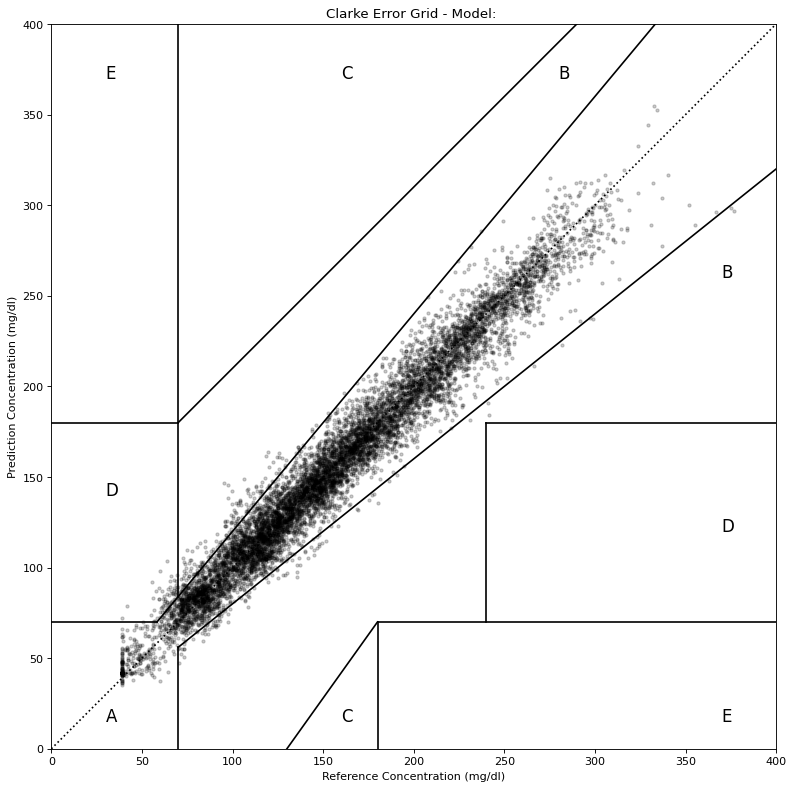

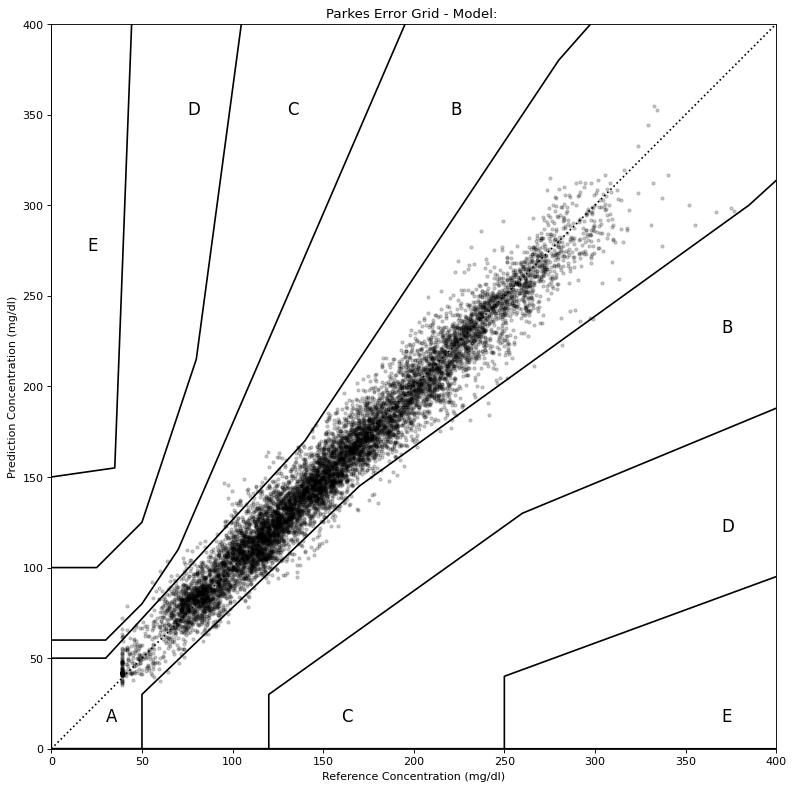

In [ ]:
# %% Evaluate model
# ---------------------------------------------------------------------
# EVALUATE THE MODEL
# ---------------------------------------------------------------------
evaluationConfiguration = {
    'distance': True,
    'hypo': True,
    'clarke': True,
    'parkes': True,
    'lag': True,
    'plotLag': True,
    'plotTimeseries': True
}
# ---------------------------------------------------------------------

evalObject = evaluateModel(data_obj, model)

import csv
if evaluationConfiguration['distance']:
    distance = evalObject.get_distanceAnalysis()
    w = csv.writer(open(model_figure_path / "distance.csv", "w"))
    for key, val in distance.items():
        w.writerow([key, val])

if evaluationConfiguration['hypo']:
    hypo = evalObject.get_hypoAnalysis()

if evaluationConfiguration['lag']:
    lag = evalObject.get_lagAnalysis(figure_path=model_figure_path)

if evaluationConfiguration['plotTimeseries']:
    evalObject.get_timeSeriesPlot(figure_path=model_figure_path)

if evaluationConfiguration['clarke']:
    clarkes, clarkes_prob = evalObject.clarkesErrorGrid(
        'mg/dl', figure_path=model_figure_path)
    
if evaluationConfiguration['parkes']:
    parkes, parkes_prob = evalObject.apply_parkes_error_grid(
        'mg/dl', figure_path=model_figure_path)



In [10]:
    w = csv.writer(open(model_figure_path / "hypo.csv", "w"))
    for key, val in hypo.items():
        w.writerow([key, val])


NameError: ignored